# Background

We are using the `titanic` dataset to predict passenger survival. The dataset is classic for a reason, it is perfect for testing various ML algorithms.

# Data Exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train = pd.read_csv("train.csv")
holdout = pd.read_csv("test.csv")

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Helper functions to process the different variables.

In [3]:
# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [4]:
def process_dummies(dataframe):
    new_df = process_missing(dataframe)
    new_df = process_age(new_df)
    new_df = process_fare(new_df)
    new_df = process_titles(new_df)
    new_df = process_cabin(new_df)
    
    for col in ['Age_categories','Fare_categories',
                'Title','Cabin_type','Sex']:
        new_df = create_dummies(new_df,col)
        
    return new_df

In [5]:
train = process_dummies(train)
holdout = process_dummies(holdout)

In [6]:
train[['SibSp','Parch']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   SibSp   891 non-null    int64
 1   Parch   891 non-null    int64
dtypes: int64(2)
memory usage: 14.0 KB


<AxesSubplot:xlabel='SibSp', ylabel='count'>

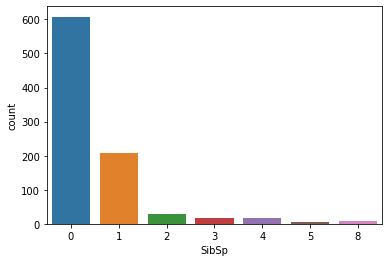

In [7]:
sns.countplot(x = train['SibSp'])

<AxesSubplot:xlabel='Parch', ylabel='count'>

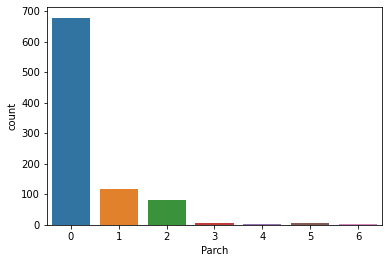

In [8]:
sns.countplot(x = train['Parch'])

In [9]:
train.pivot_table(values='Survived',index=['SibSp'])

,Survived
SibSp,
0,0.345395
1,0.535885
2,0.464286
3,0.250000
4,0.166667
5,0.000000
8,0.000000


In [10]:
train.pivot_table(values='Survived',index='Parch')

,Survived
Parch,
0,0.343658
1,0.550847
2,0.500000
3,0.600000
4,0.000000
5,0.200000
6,0.000000


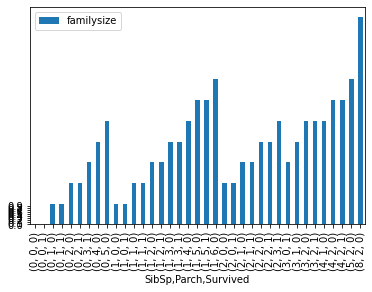

In [11]:
explore_cols = ["SibSp","Parch","Survived"]
explore = train[explore_cols].copy()

explore['familysize'] = explore[["SibSp","Parch"]].sum(axis=1)
pivot = explore.pivot_table(index=explore_cols,values="Survived")
pivot.plot.bar(yticks=np.arange(0,1,.1))
plt.show()

Explain findings here

In [12]:
def passenger_alone(dataframe):
    dataframe['family_size'] = dataframe['SibSp'] + dataframe['Parch']
    dataframe['isalone'] = dataframe['family_size'].apply(
        lambda x: 1 if x == 0 else 0)
    return dataframe

In [13]:
train = passenger_alone(train)
holdout = passenger_alone(holdout)

# Feature Engineering and Selection

In [14]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

In [15]:
def select_features(dataframe):
    new_df = dataframe.copy()
    new_df = new_df.select_dtypes(include=[int, float, bool])
    new_df = new_df.dropna(axis=1)
    
    all_X = new_df.drop(["Survived","PassengerId"],axis=1)
    all_y = new_df['Survived']
    
    rfc = RandomForestClassifier(random_state = 1)
    selection = RFECV(rfc, all_X, all_y, cv=10)
    best_cols = list(selection.get_params()['step'].columns)
    print(best_cols)
    return best_cols

In [16]:
best_cols = select_features(train)

['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'family_size', 'isalone']


/home/jupyter-pomkos/.conda/envs/data_env/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass step=     Pclass   Age  SibSp  Parch     Fare  family_size  isalone
0         3  22.0      1      0   7.2500            1        0
1         1  38.0      1      0  71.2833            1        0
2         3  26.0      0      0   7.9250            0        1
3         1  35.0      1      0  53.1000            1        0
4         3  35.0      0      0   8.0500            0        1
..      ...   ...    ...    ...      ...          ...      ...
886       2  27.0      0      0  13.0000            0        1
887       1  19.0      0      0  30.0000            0        1
888       3  -0.5      1      2  23.4500            3        0
889       1  26.0      0      0  30.0000            0        1
890       3  32.0      0      0   7.7500            0        1

[891 rows x 7 columns], min_features_to_select=0      0
1      1
2      1
3      1
4      0
      ..
886    0
887   

# Model Selection/Tuning

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [18]:
def select_model(dataframe, features):
    all_X = dataframe[features]
    all_y = dataframe['Survived']
    
    model_list = [
        {
            'name':'LogisticRegression',
            'estimator':LogisticRegression(),
            'hyperparameters':{
                'solver':['newton-cg','lbfgs','liblinear']
            }
        },
        {
            'name':"KNN",
            'estimator':KNeighborsClassifier(),
            'hyperparameters':{
                'n_neighbors':range(1,20,2),
                'weights':['distance','uniform'],
                'algorithm':['ball_tree','kd_tree','brute'],
                'p':[1,2]
            }
        },
        {
            'name':'RandomForest',
            'estimator':RandomForestClassifier(),
            'hyperparameters':{
                "n_estimators": [4, 6, 9],
                "criterion": ["entropy", "gini"],
                "max_depth": [2, 5, 10],
                "max_features": ["log2", "sqrt"],
                "min_samples_leaf": [1, 5, 8],
                "min_samples_split": [2, 3, 5],   
            }
        }
    ]
    for model in model_list:
        print(model['name'])
        grid = GridSearchCV(model['estimator'],
                            param_grid=model['hyperparameters'],
                            cv=10)
        grid.fit(all_X,all_y)
        model['params'] = grid.best_params_
        model['score'] = grid.best_score_
    
    best_score = 0
    for model in model_list:
        if model['score'] > best_score:
            best_score = model['score']
    
    for model in model_list:
        if model['score'] == best_score:
            model['estimator'] = grid.best_estimator_
            
            print(model['params'])
            print(model['score'])
            
    return model_list

In [19]:
model_list = select_model(train, best_cols)

LogisticRegression


/home/jupyter-pomkos/.conda/envs/data_env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


KNN
RandomForest
{'criterion': 'entropy', 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 6}
0.7375031210986267


# Save or Submit

In [20]:
def save_submission_file(trained_model, cols, filename='submit.csv'):
    prediction = trained_model.predict(holdout[cols])
    submission = pd.DataFrame({
        'PassengerId':holdout['PassengerId'],
        'Survived':prediction
    })
    
    submission.to_csv(filename, index=False)

In [21]:
model = model_list[2]['estimator']
model_list[2]

{'name': 'RandomForest',
 'estimator': RandomForestClassifier(criterion='entropy', max_depth=5, max_features='log2',
                        min_samples_split=5, n_estimators=6),
 'hyperparameters': {'n_estimators': [4, 6, 9],
  'criterion': ['entropy', 'gini'],
  'max_depth': [2, 5, 10],
  'max_features': ['log2', 'sqrt'],
  'min_samples_leaf': [1, 5, 8],
  'min_samples_split': [2, 3, 5]},
 'params': {'criterion': 'entropy',
  'max_depth': 5,
  'max_features': 'log2',
  'min_samples_leaf': 1,
  'min_samples_split': 5,
  'n_estimators': 6},
 'score': 0.7375031210986267}

In [22]:
save_submission_file(model, best_cols, filename='randomtitanic.csv')

# Next Steps

In this guided project, we created a reproducible workflow to help us iterate over ideas and continue to improve the accuracy of our predictions. We also created helper functions which will make feature selection, model selection/tuning and creating submissions much easier as we continue to explore the data and create new features.

Kaggle Workflow

We encourage you to continue working on this Kaggle competition. Here are some suggestions of next steps:

    Continue to explore the data and create new features, following the workflow and using the functions we created.
    Read more about the titanic and this Kaggle competition to get ideas for new features.
    Use some different algorithms in the select_model() function, like support vector machines, stochastic gradient descent or perceptron linear models.
    Experiment with RandomizedSearchCV instead of GridSearchCV to speed up your select_features() function.

You can continue to work on this Kaggle competition within this guided project environment and save out files for submission if you like, although we would encourage you to set up your own Python environment so that you can work on your own computer. We have a Python Installation Guide that walks you through how to do this.

Lastly, while the Titanic competition is great for learning about how to approach your first Kaggle competition, we recommend against spending many hours focused on trying to get to the top of the leaderboard. With such a small data set, there is a limit to how good your predictions can be, and your time would be better spent moving onto more complex competitions.

Once you feel like you have a good understanding of the Kaggle workflow, you should look at some other competitions - a great next competition is the House Prices Competition. We have a great tutorial for getting started with this competition on our blog.

Curious to see what other students have done on this project? Head over to our Community to check them out. While you are there, please remember to show some love and give your own feedback!

And of course, we welcome you to share your own project and show off your hard work. Head over to our Community to share your finished Guided Project!